# Cross validataion notebook

notebook to split place cell data into even and odd laps and perform cross validation of place cells 

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import h5py
import numpy as np
import pandas as pd
from scipy.ndimage import uniform_filter1d, gaussian_filter1d, gaussian_filter
from scipy.stats import pearsonr
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
from IPython.display import display, clear_output
import ipywidgets as widgets

from utils.placecell_functions import *
from utils.placecell_ploting import *
from utils.placecell_classes import data_loader, animal_widgets

In [2]:
data_dir = "../data/"
save_location = "../output_data/"
output_dir = "../output_figs/"

exp_sets = ['mcherry']
data_sets = ['Day2 - Squ-Tri-Tri','Day4 - Tri-Tri-Tri', 'Day5 - Tri-OptoTri-Tri', 'Day6 - Tri-OptoHex-Hex']

data_titles = ['Day2 - Familiar - Novel - Novel','Day4 - Familiar - Familiar - Familiar', 'Day5 - Familiar - OptoFamiliar - Familiar', 'Day6 - Familiar - OptoNovel - Novel']
session_names = [["Familiar", "Novel", "Novel"],["Familiar", "Familiar", "Familiar"],["Familiar", "OptoFamiliar", "Familiar"],["Familiar", "OptoNovel", "Novel"]]

data_filenames = ['ratemap_structure_day2.mat','ratemap_structure_day4.mat','ratemap_structure_day5.mat','ratemap_structure_day6.mat']


opto_actual_bins = [8, 20] #These are the zones that contained opto frames but the edges hardly had any
control_actual_bins = [21, 33] #This is the oposite of that zone. 
opto_bins = [10,18] # inclusive and based on zero index (added +1 when indexing)
control_bins = [21,29] # inclusive and based on zero index (added +1 to second element when indexing)


# colour palettes used for the plotting
purple_green_pallette = [(0.24423453, 0.20678459, 0.41985299), (0.29215894, 0.76144162, 0.67886578)]
purple_orange_pallette = [(0.24423453, 0.20678459, 0.41985299), (0.9411764705882353, 0.5607843137254902, 0.2901960784313726)]

purple_green_pallette_point = [(0.44423453, 0.40678459, 0.61985299), (0.29215894, 0.76144162, 0.67886578)]
purple_orange_pallette_point = [(0.44423453, 0.40678459, 0.61985299), (0.9490196078431372, 0.6784313725490196, 0.45098039215686275)]


joint_pal = [purple_orange_pallette, purple_green_pallette]
joint_pal_point = [purple_orange_pallette_point, purple_green_pallette_point]


In [3]:
# callback function to redraw widgets when dataset changes
def update_widgets(change):
    animals.create_widget(output_widget)
    

sort_by = widgets.RadioButtons(
        options=['Session 1', 'Session 2', 'Session 3'],
        index = 1,
        description='Ratemap to align to:',
        disabled=False,
        button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    )

activity_type = widgets.Select(
                options=["All activity","Place activity"],
                index=0,
                rows = 2,
                description='Activity type:',
                disabled=False,
                style= {'description_width': 'initial'}
            )

show_opto = widgets.Checkbox(
            value=False,
            description='Show optozone',
            disabled=False,
            indent=False
        )

ratemap_type = widgets.Select(
                options=["All cell rates","Place cells"],
                index=0,
                rows = 2,
                description='Ratemap type:',
                disabled=False,
                style= {'description_width': 'initial'}
            )


# create an instance of the data loader
data = data_loader(data_dir, exp_sets, data_sets, data_filenames, data_titles, session_names)

# observe when the data object changes
data.data_widget.observe(update_widgets, names = 'value')

#create an output widget that will hold the FOV image or the selection widget
output_widget = widgets.Output() 

#create animals widgets
animals = animal_widgets(output_widget, data)

#display all of the widgets
display(data.exp_widget)
display(data.data_widget)
display(animals.create_widget(output_widget)) 
display(activity_type)
display(ratemap_type)
display(sort_by)
display(show_opto)


RadioButtons(description='Experiments:', options=('mcherry',), value='mcherry')

RadioButtons(description='Dataset:', options=('Day2 - Squ-Tri-Tri', 'Day4 - Tri-Tri-Tri', 'Day5 - Tri-OptoTri-…

Output()

Select(description='Activity type:', options=('All activity', 'Place activity'), rows=2, style=DescriptionStyl…

Select(description='Ratemap type:', options=('All cell rates', 'Place cells'), rows=2, style=DescriptionStyle(…

RadioButtons(description='Ratemap to align to:', index=1, options=('Session 1', 'Session 2', 'Session 3'), val…

Checkbox(value=False, description='Show optozone', indent=False)

### Process the data from widget

In [4]:
session_index = sort_by.index

behaviour_dict = data.behaviour_dict
spikes_dict = data.spikes_dict
placecell_rates_dict = data.placecell_rates_dict

animal_id = animals.selection.value
ids_to_pool = animals.ids_to_pool.value

if animal_id == 'pooled data':
    animals_to_analyse = ids_to_pool
else:
    animals_to_analyse = animal_id


placecell_rates = create_pooled_data(placecell_rates_dict,ids_to_pool)


### Get even and odd ratemaps

In [5]:
even_rates_list = []
odd_rates_list = []
for id in animals_to_analyse:
    coords = behaviour_dict[id][session_index]['x_coord']
    coords = interp_for_nans(coords) #found edge case where there are nans in coords
    times = behaviour_dict[id][session_index]['frame_time']
    
    spike_times = spikes_dict[id][session_index]['spike times']
    is_placecell = spikes_dict[id][session_index]['is_placecell'].astype(bool)
    place_ids = spike_times.columns[is_placecell]

    event_time_dic = {}
    for cell_id in place_ids:
        spikes = spike_times[cell_id].values
        spikes = spikes[~np.isnan(spikes)] # drop the nan values
        event_time_dic[cell_id] = spikes
    even_ratemaps, odd_ratemaps, ids = get_even_odd_ratemaps(coords,
                                                        times,
                                                        event_time_dic)
    
    even_ratemaps = pd.DataFrame(even_ratemaps, index = ids)
    odd_ratemaps = pd.DataFrame(odd_ratemaps, index = ids)
   

    even_rates_list.append(even_ratemaps)
    odd_rates_list.append(odd_ratemaps)


even_ratemaps_all = pd.concat(even_rates_list)
odd_ratemaps_all = pd.concat(odd_rates_list)

### Sort the ratemaps based on even or odd

sort just even and odd

In [6]:
sort_by_rates = even_ratemaps_all
sorted_to_rates = odd_ratemaps_all

sort_id, _ = sort_ratemaps(sort_by_rates)

sorted_by_rates = sort_by_rates.reindex(sort_id).fillna(0)
sorted_to_rates = sorted_to_rates.reindex(sort_id).fillna(0)

# rates_sum = sorted_by_rates.sum(axis=1)
# index_zero_rates = rates_sum[rates_sum == 0].index

# sorted_to_rates = sorted_to_rates.drop(index_zero_rates)
# sorted_by_rates = sorted_by_rates.drop(index_zero_rates)


rates_to_plot = [sorted_by_rates, sorted_to_rates]
subplot_titles = ['Even laps', 'Odd laps']

Align to all the laps and show even and odd

In [7]:
both_ratemaps = placecell_rates[session_index]

sort_by_rates = both_ratemaps

sort_id, _ = sort_ratemaps(sort_by_rates)

sorted_by_rates = both_ratemaps.reindex(sort_id).fillna(0)
sorted_to_rates = even_ratemaps_all.reindex(sort_id).fillna(0)
sorted_to_rates2 = odd_ratemaps_all.reindex(sort_id).fillna(0)

# rates_sum = sorted_by_rates.sum(axis=1)
# index_zero_rates = rates_sum[rates_sum == 0].index

# sorted_to_rates = sorted_to_rates.drop(index_zero_rates)
# sorted_by_rates = sorted_by_rates.drop(index_zero_rates)

rates_to_plot = [sorted_by_rates, sorted_to_rates, sorted_to_rates2]
subplot_titles = ['All laps','Even laps', 'Odd laps']

### Plot the ratemaps

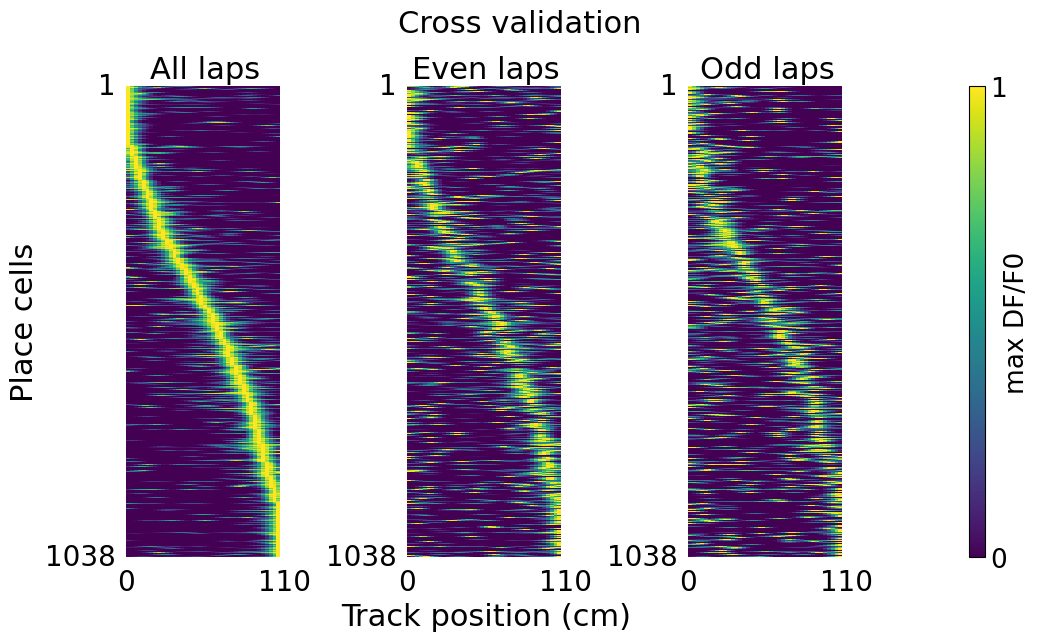

In [8]:
# set some varibles for the plotting
number_bins = 40
num_rates = rates_to_plot[0].shape[0]

figure_title = 'Cross validation'
colormap = 'viridis'
opto_zone_color = 'cyan'
fontsize = 20
plot_opto = False

subplot_dims = len(rates_to_plot)
subplot_widths = np.append(np.ones(subplot_dims), 0.1)

# create a subplot including one for the color bar 
fig, axs = plt.subplots(1,subplot_dims+1, gridspec_kw={'width_ratios': subplot_widths}, figsize=(subplot_dims*3.5, 6.5))
fig.suptitle(figure_title, fontsize=fontsize+2)

for i, rates in enumerate(rates_to_plot):

    # plot the data as a seaborn heatmap
    im = sns.heatmap(np.array(rates), cmap=colormap, ax=axs[i], cbar=False)
    
    # change the x-axis settings
    axs[i].set_xticks([0, 41])
    axs[i].set_xticklabels([0, 110], rotation=0, fontsize = fontsize)
    
    # change the y-axis settings
    axs[i].set_title(subplot_titles[i], fontsize=fontsize+2)
    axs[i].set_ylim(0, num_rates)
    axs[i].tick_params(length = 0, pad = 8)
    axs[i].set_yticks([num_rates, 1])
    axs[i].set_yticklabels([1, num_rates], rotation=0, fontsize= fontsize)
    
    # set the titles on specific subplots
    axs[1].set_xlabel("Track position (cm)", fontsize = fontsize+2)
    axs[0].set_ylabel("Place cells", fontsize = fontsize+2)

    # Create the colorbar on the fourth axis
    cbar = fig.colorbar(im.collections[0], cax=axs[-1])
    cbar.ax.tick_params(labelsize=fontsize-1, length=0)
    cbar.set_label('max DF/F0', labelpad=-2, fontsize=fontsize-1)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels([0, 1], fontsize = fontsize-1)


# if want to plot the zone for opto
if plot_opto:
    for zone in opto_actual_bins:
        [axs[i].axvline(x = zone, linewidth=1.5, linestyle='--', color=opto_zone_color, alpha = 0.5) for i in range(len(rates_to_plot))]


plt.tight_layout()

In [9]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams['svg.fonttype'] = 'none'
save_path = f"../output_figs/cross_validation/cross_val.svg"
fig.savefig(save_path, format='svg')


# Save only the heatmap part as PNG
save_path_png = "../output_figs/cross_validation/cross_val.png"
fig.savefig(save_path_png, format='png')